# Fashion-MNIST

Fashion MNIST is a MNIST-like fashion product database consists 60.000 training images and 10.000 test images. Each image is a greyscale and associated with a label from 10 classes.

### Challenges in Computer Vision (CV)


One of the most useful in Deep Learning for Computer Vision are Convolution Neural Networks (CNNs). Today they are the most sophisticated fancy computer vision application.

In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Reading the csv file into it

In [2]:
df_train = pd.read_csv("data/fashion-mnist_train.csv")
df_test = pd.read_csv("data/fashion-mnist_test.csv")

print(f'df_train: {df_train.shape}')
print(f'df_test: {df_test.shape}')

df_train: (60000, 785)
df_test: (10000, 785)


Define our images and labels

In [3]:
X_train = df_train.drop(['label'], axis=1)
y_train = df_train['label']
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')

X_train: (60000, 784)
y_train: (60000,)


We make a train, val and test split for our models

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/6, random_state=0)

X_test = df_test.drop(['label'], axis = 1)
y_test = df_test['label']

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (50000, 784)
y_train shape: (50000,)
X_val shape: (10000, 784)
y_val shape: (10000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


In [5]:
class FashionMNIST(Dataset):
    """
    X : pandas.DataFrame (images)
    y : pandas.Series (labels)
    transform : list of data augmentation
    """
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __getitem__(self, index):
        # PyTorch automatically divide image data by 255 when its data type is np.uint8 
        # (np.uint8 : unchanged sign value [0 ~ 255])
        image = self.X.iloc[index, :].values.astype(np.uint8).reshape((28, 28, 1)) # (height, width, channels)
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.y is not None: # training
            return image, self.y.iloc[index]
        else: # prediction
            return image
        
    def __len__(self):
        return len(self.X.index)


In [6]:
BATCH_SIZE = 128
lr = 0.01
NUM_CLASS = 10
TRAIN_EPOCH = 20
IMAGE_SIZE = 28
CHANNEL = 1

#Class names
class_clothing = {0: 'T-shirt/top',
                  1: 'Trouser',
                  2: 'Pullover',
                  3: 'Dress',
                  4: 'Coat',
                  5: 'Sandal',
                  6: 'Shirt',
                  7: 'Sneaker',
                  8: 'Bag',
                  9: 'Ankle boot'}

### DataLoader

In [13]:
My_transform = transforms.Compose([
    transforms.ToTensor(),# default : range [0, 255] -> [0.0,1.0]
])

train_dataset = FashionMNIST(X_train, y_train, transform=My_transform)

val_dataset = FashionMNIST(X_val, y_val, transform=My_transform)

test_dataset = FashionMNIST(X_test, y_test, transform=My_transform)


Train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle=False
                              )
Val_dataloader = DataLoader(dataset=val_dataset,
                               batch_size = BATCH_SIZE,
                               shuffle=False)

Test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle=False
                              )

### Visualization

In [23]:
img, lab = train_dataset.__getitem__(0)
print(img.shape)

torch.Size([1, 28, 28])


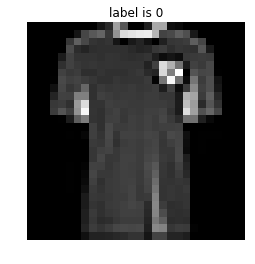

In [24]:
full_img = img.numpy().flatten().reshape((28,28))

plt.imshow(full_img, cmap='gray')
plt.title(f'label is {lab}')
plt.axis('off')
plt.show()

In [25]:
train_iter = iter(Train_dataloader)
images, labels = next(train_iter)

print(f'train_dataset_img shape: torch.Size([BATCH_SIZE, CHANNEL, IMAGE_SIZE, IMAGE_SIZE])')
print(f'train_dataset_lab shape: torch.Size([BATCH_SIZE])')

train_dataset_img shape: torch.Size([BATCH_SIZE, CHANNEL, IMAGE_SIZE, IMAGE_SIZE])
train_dataset_lab shape: torch.Size([BATCH_SIZE])


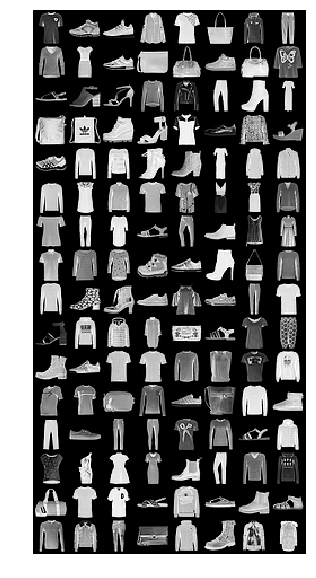

In [26]:
grid = make_grid(images, nrow=8)

fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(grid.numpy().transpose((1,2,0)))
ax.axis('off')
plt.show()

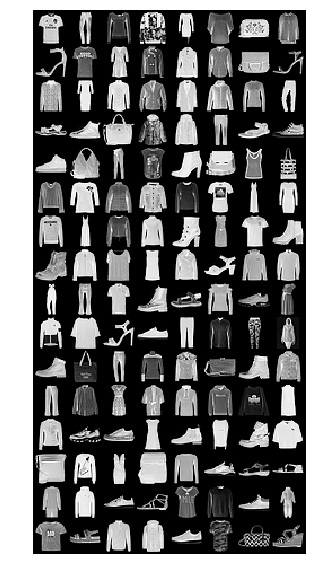

In [27]:
test_iter = iter(Test_dataloader)
images, labels = next(test_iter)

grid = make_grid(images, nrow=8)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(grid.numpy().transpose((1, 2, 0)))
ax.axis('off');

Idee: Wir interpretieren die Abfolge der Bild-Spalten als Sequenz und die Einträge der Bilderspalten als Feature.

## Building model

Before diving into convolutional neural networks, let's take a quick overview of the traditional techniques used in computer vision.

## Overview of Traditional Approaches

Various techniques work well for simpler problems, but if the task complex, they are no substitute for deep CNNS. Let's discuss two simple approaches:

1. KNN (K-Nearest Neighbours):

Each image is matched with all images in data. The top K with minimum distances (e.g. L1 distance or L2 distance) are selected. The majority class of those top K is predicted as output class of the image.

Problem: If we have the same object in a picture with different illumination, orientation or location then KNN would give highly non-zero distance for the same images.

2. Linear Classifiers:

They use a parametric approach where each pixel value is considered as a parameter.
It is a weighted sum of the pixel values with the dimension of the weights matrix depending on the number of outcomes.

## Review of Neural Networks

We recall the basics of neural networks here und discuss some properties. 

There are various activation functions which can be used. Let's discuss some of the popular options:

### Activiation Functions

#### Sigmoid activation

- Equation: sigma(x) = 1/(1 + e ^ (-x) ) with input space from (- infinity, + infinity) to (0,1)

- It has some problems and it is almost never used in CNNs:
    1. If the input beyond -5 or 5, the output will be very close to 0 and 1 respectively. That means, the gradients are almost zero. As we know that gradients get multiplied in backpropagation, so this small grdient will stop backpropagation into further layers.

- Outputs are nont zero-centered
    2. As we know the outputs are between 0 and 1, i.e. all the gradients of the next layer will be either positive or negative. So the path to optimum will be zig-zag. 
    
- Taking the exponential function is computationally expensive
    3. It has a slight negative impact
    
#### tanh activation

- Equation: tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))

- It is always preferred over sigmoid because the outputs are in range(-1,1). But it will still result in killigin the gradient.

#### ReLu (Rectrified LInear Unit) activation

- Equation: f(x) = max(0,x)

- It is the most commonly used activation function for CNNs. It has some advantages:
    - Gradient will not saturate in the positive region
    - Computationally very efficient as simple thresholding is required
    - Empirically found to converge faster than sigmoid or tanh
    
- But it has the following disadvantages:
    - Output is not zero-centered and always positive
    - Gradient is killed for x < 0.
    
Summary: ReLU is mostly the activation function of choice. 

## Introduction to Convolution Neural Networks

### A CNN typically consists of 3 types of layers:

1. Convolution Layer
2. Pooling Layer
3. Fully connected Layer

### Convolution Layer

Since Convolution layers from the crux of the network. Each layer can be visualized in the form of a block. For instance in the case of FASHION-MNIST, input layer would have the following form: (1, 28, 28)

The original image has 28x28 in height and width. Sometimes the depth is 3 which corresponds to the Red, Green and Blue colors, which form the basis of colored images.

A Convolultion layer is formed by running a filter over it. A filter is another block of smaller height and width but same depth which is swept over this base block.

We start this filter from the top left corner and sweep it till the bottom it till the bottom left corner. This filter is a set of weights, i.e. in our case 5x5 = 25 + 1 weights. Our term stride, which is the number of cells to move in each step is one (stride=1). Then the output size will be: (Convolutional layer dim - Filter dim) / Stride + 1. The output is 24 pixels which we get from this formula. This is undesirable in case of deep neural networs where the size would become very small too early. To prevent this, we generally use a stride of 1 along with zero-padding of size (Filter dim - 1)/2. Zero-padding is nothing but additional zero-value pixels towards the border of the images. The required padding is (5-1)/2 = 2. Now the image-size remains the same. 

#### Pooling Layer

Pooly layers are used to reduce the size of imag. They work by sampling in each layer using filters. If we use 2x2 filter with stride 1 and max-pooling, we get the following response:
(28 - 14 + 2) = 16

Generally, max-pooling is used but other options like average pooling ca be considered too.

#### Fully Connectecd Layer

At the end of convolution and pooling layers, networks generally use fully-connected layers in which each pixel is considered as a seperate neuron just like a regular neural network. The last fully-connect layer will contain as many neurons as the number of classes to be predicted. In our case 10 neurons.

In [7]:
class CNN(nn.Module):
    
    def __init__(self, num_of_class):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)  # convert data shape (64, 1, 28, 28) -> (64, 1*28*28) = [64,784]
        out = self.fc(out)
        return out

In [8]:
class MLP(nn.Module):
    
    def __init__(self, num_of_classes):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(28*28*1, 100),
            nn.ReLU(),
            nn.Linear(100, num_of_classes) # 10 because we have 10 different classes
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # convert data shape (64, 1, 28, 28) -> (64, 1*28*28) = [64,784]
        x = self.layers(x)
        return x

In [9]:
def train_val(model):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss()
    
    mean_train_loss = []
    mean_val_loss = []
    
    for epoch in range(TRAIN_EPOCH):
        
        model.train()
        
        train_loss = []
        val_loss = []
        for batch_id, (images, labels) in enumerate(Train_dataloader):
            
            # zero the paramters gradient
            optimizer.zero_grad()
            
            # feedforward -> backward -> optimize
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            train_loss.append(loss.data)
            loss.backward()
            optimizer.step()
            
            if (batch_id * BATCH_SIZE) % (BATCH_SIZE * 100) == 0:
                print(f'{batch_id * BATCH_SIZE} / 50000')
        
        # Each Epoch we validate our model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_id, (images, labels) in enumerate(Val_dataloader):
                
                # feedforward -> loss
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss.append(loss.data)

                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        mean_train_loss.append(np.mean(train_loss))
        mean_val_loss.append(np.mean(val_loss))
    
        print('Epoch:[{}/{}], train loss : {:.4f}, valid loss : {:.4f}, val acc : {:.2f}%'\
              .format(epoch+1, TRAIN_EPOCH, np.mean(train_loss),\
                               np.mean(val_loss), 100*correct/total))
    
    # Plotting our test and val losses
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(mean_train_loss, label='train')
    ax.plot(mean_val_loss, label='val')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    plt.ylim(0.05,0.8)
    plt.show()
    
    return model

In [10]:
def test(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_id, (images, labels) in enumerate(Test_dataloader):
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [11]:
model = CNN(NUM_CLASS)

In [ ]:
#train_val(model1)

In [14]:
if __name__ == '__main__':
    model = train_val(model)
    test(model)

0 / 50000
12800 / 50000
25600 / 50000


KeyboardInterrupt: 